### Imports.

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.optim as optim

from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose

### Device.

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Current device: {}'.format(device))

Current device: cpu


### Dataset.

In [3]:
# Fashion-MNIST Dataset.
# Training.
train_dataset = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)
# We use the training dataset as validation dataset.
valid_dataset = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

In [4]:
# Dataset subclass to sample images during training.
class CustomImageDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    # Define len dunder method. Dunder stands for double underscore.
    def __len__(self):
        return len(self.dataset)
    # Define getitem dunder method.
    def __getitem__(self, index):
        # Get image with it's corresponding classification label.
        image, label = self.dataset[index]
        # Replace classification label with flattened version of image.
        label = torch.flatten(image)
        return image, label
    
# Why we replace classification label with flattened version of image.
# With an autoencoder, the output of the neural network is an image. When evaluating the loss function we want to compare
# the output with the "correct answer", which is the original image.

In [5]:
# Use the Fashion-MNIST datasets as instances of this class.
train_dataset = CustomImageDataset(train_dataset)
valid_dataset = CustomImageDataset(valid_dataset)

### Autoencoder.

In [6]:
# Autoencoder class as a subclass of nn.Module (neural network module).
# Structure of the neural network is:
#    28*28 input layer.
#    n_hidden hidden layer. Default value is 64.
#    28*28 output layer.
# The dropout probability is p_dropout. Default value is 0.1.
class Autoencoder(nn.Module):
    def __init__(self, n_hidden = 64, p_dropout = 0.1):
        super().__init__()
        # Structure.
        self.linear1 = nn.Linear(28*28, n_hidden)
        self.linear2 = nn.Linear(n_hidden, 28*28)
        # Functions.
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p_dropout)
        
    # Method to compute output tensor from input tensor.
    def forward(self, input_tensor):
        input_tensor = self.flatten(input_tensor)
        input_tensor = self.linear1(input_tensor)
        input_tensor = self.dropout(input_tensor)
        input_tensor = self.relu(input_tensor)
        # Note: dropout is usually applied after the activation function. When using rectified linear units,
        # we apply it before the activation function since in this case the order doesn't matter and it's 
        # more computationally efficient.
        input_tensor = self.linear2(input_tensor)
        # Return input_tensor as output.
        return input_tensor

### Training and Testing.

In [7]:
# Training function.
def train(dataloader, model, loss_function, optimizer, sample_data = False, sample_data_threshold = 20):
    if sample_data:
        num_samples_total = len(dataloader.dataset)
    # Set training mode.
    model.train()
    ##model = model.to(device) for gpu.
    # Iteration.
    for batch, (input_tensor, reference_tensor) in enumerate(dataloader):
        ###input_tensor = input_tensor.to(device) for gpu.
        ###reference_tensor = reference_tensor.to(device) for gpu.
        # Calculate output tensor and evaluate loss function.
        output_tensor = model(input_tensor)
        loss = loss_function(output_tensor, reference_tensor) 
        
        # Backpropagation using corresponding optimizer.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if sample_data:
            if batch % sample_data_threshold * len(input_tensor) == 0:
                # Get loss as a number.
                loss = loss.item()
                # Get total number of processed samples as batch number times number of samples in each batch.
                num_samples = batch * len(input_tensor)
                # Print progress.
                print("Batch: {}. Processed {}/{} samples. Loss: {:.8f}.".format(batch, num_samples, num_samples_total, loss))
                
# Testing function.
def test(dataloader, model, loss_function):
    #num_samples_total = len(dataloader.dataset) no need.
    num_batches_total = len(dataloader)
    total_loss = 0
    # Set evaluation mode.
    model.eval()
    ###model = model.to(device) for gpu.
    # Disabling gradient calculation
    with torch.no_grad():
        # Iteration.
        for input_tensor, reference_tensor in dataloader:
            ###input_tensor = input_tensor.to(device) for gpu.
            ###reference_tensor = reference_tensor.to(device) for gpu.
            # Calculate output tensor and evaluate loss function.
            output_tensor = model(input_tensor)
            loss = loss_function(output_tensor, reference_tensor)
            # Add calculated loss to the total_loss variable.
            total_loss += loss.item()
    # Calculate average loss.
    average_loss = total_loss / num_batches_total
    return average_loss

### Parameter initialization and training loop.

In [8]:
# Training parameters.
learning_rate = 1e-3
batch_size = 1000
num_epochs = 400

# Dataloaders; iterables over datasets.
train_dataloader = DataLoader(train_dataset, batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size)

# Autoencoder parameters.
n_hidden_list = [64, 128, 256, 512]
p_dropout = 0.1

# Loss function; mean squared error.
loss_function = nn.MSELoss()

# DataFrame to store calculated values.
df = pd.DataFrame()
save_loss = True

# Save model variable.
save_model = True

In [9]:
for n_hidden in n_hidden_list:
    print("n_hidden: {}\n-------------------------------".format(n_hidden))
    # Initialize autoencoder.
    model = Autoencoder(n_hidden, p_dropout)
    # Optimizer.
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    
    for epoch in range(num_epochs):
        # Train autoencoder.
        train(train_dataloader, model, loss_function, optimizer)
        # Evaluate loss function.
        train_loss = test(train_dataloader, model, loss_function)
        valid_loss = test(valid_dataloader, model, loss_function)
        if save_loss:
            # Add values to DataFrame.
            df = df.append({"n_hidden": n_hidden, 
                            "epoch": epoch + 1, 
                            "train_loss": train_loss, 
                            "valid_loss": valid_loss},
                            ignore_index = True)
            # Safety save.
            df.to_pickle(r"models\safety.pkl")
            
        if (epoch + 1) % 100 == 0:
            print("Epoch: {}. Train Loss: {}. Validation Loss: {}.".format(epoch + 1, train_loss, valid_loss))
            
    if save_model:
        model_filename = r"models\nh{}-lr{:.0e}-bs{}-ne{}.pth".format(n_hidden, learning_rate, batch_size, num_epochs)
        torch.save(model.state_dict(), model_filename)
        
    print("n_hidden: {}. Done!\n-------------------------------".format(n_hidden))
        
if save_loss:
    # Save DataFrame.
    df.to_pickle(r"models\dataframe.pkl")

n_hidden: 64
-------------------------------
Epoch: 100. Train Loss: 0.018528812595953546. Validation Loss: 0.01854099314659834.
Epoch: 200. Train Loss: 0.018110949856539566. Validation Loss: 0.018151700496673584.
Epoch: 300. Train Loss: 0.018110110983252527. Validation Loss: 0.018158110976219177.
Epoch: 400. Train Loss: 0.018107159497837224. Validation Loss: 0.018159336969256402.
n_hidden: 64. Done!
-------------------------------
n_hidden: 128
-------------------------------
Epoch: 100. Train Loss: 0.01301157755466799. Validation Loss: 0.013075677026063205.
Epoch: 200. Train Loss: 0.012782226409763097. Validation Loss: 0.012853032629936933.
Epoch: 300. Train Loss: 0.012739830914263924. Validation Loss: 0.012807813473045826.
Epoch: 400. Train Loss: 0.012687487388029694. Validation Loss: 0.012753735762089491.
n_hidden: 128. Done!
-------------------------------
n_hidden: 256
-------------------------------
Epoch: 100. Train Loss: 0.007454462310609718. Validation Loss: 0.007574512949213

### Plots.

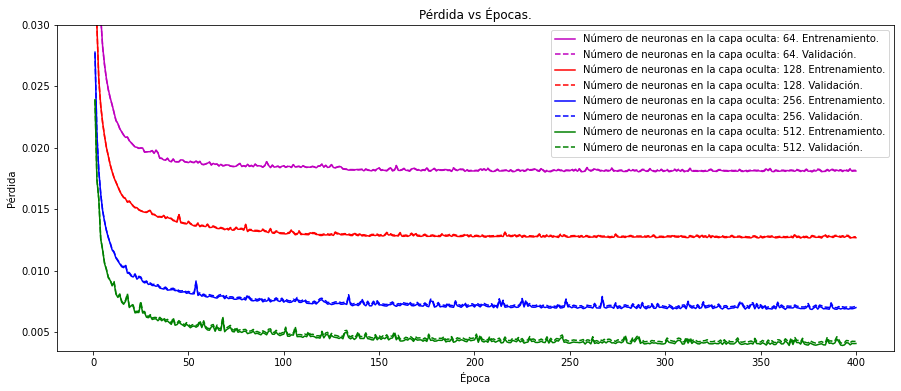

In [31]:
# Load DataFrame.
df = pd.read_pickle(r"models\dataframe.pkl")

# Color scheme. Depends on values for n_hidden.
colors = ["k", "b", "g", "r", "m"]

for n_hidden in n_hidden_list:
    xax = np.arange(num_epochs) + 1
    yax = df[df["n_hidden"] == n_hidden]
    plt.plot(xax, yax["train_loss"].to_numpy(), color = colors[n_hidden % 5], linestyle = "solid", label = "Número de neuronas en la capa oculta: {}. Entrenamiento.".format(n_hidden))
    plt.plot(xax, yax["valid_loss"].to_numpy(), color = colors[n_hidden % 5], linestyle = "dashed", label = "Número de neuronas en la capa oculta: {}. Validación.".format(n_hidden))
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.title("Pérdida vs Épocas.")
plt.ylim(0.0035, 0.030)
#plt.ylim(0.004, 0.005)
plt.rcParams["figure.figsize"] = (17.5,7)
plt.show()

In [10]:
# Load models.
models = {}
for n_hidden in n_hidden_list:
    model = Autoencoder(n_hidden, p_dropout)
    model_filename = r"models\nh{}-lr{:.0e}-bs{}-ne{}.pth".format(n_hidden, learning_rate, batch_size, num_epochs)
    model.load_state_dict(torch.load(model_filename))
    model.eval()
    models[str(n_hidden)] = model
    
models["64"]

Autoencoder(
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=784, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

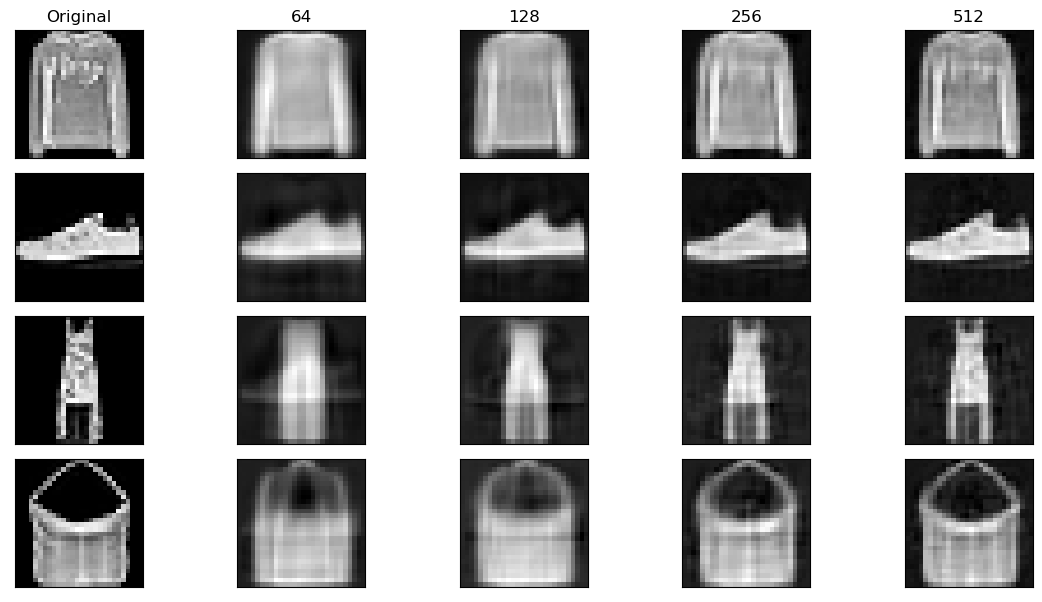

In [14]:
# Random image results.
import random
num_images = 4

fig, axes = plt.subplots(num_images, len(n_hidden_list) + 1)

for index in range(num_images):
    # Get random index for image.
    sample_index = random.randrange(len(valid_dataset))
    
    # Get corresponding image from dataset.
    sample_input, sample_image = valid_dataset[sample_index]
    
    # Reshape sample image.
    sample_image = sample_image.detach().numpy().reshape(28, 28)
    
    # Plot sample image.
    axes[index, 0].imshow(sample_image, cmap = "gray")
    axes[index, 0].set_xticks([])
    axes[index, 0].set_yticks([])

    # Get corresponding outputs
    for n_index, n_hidden in enumerate(n_hidden_list):
        model = models[str(n_hidden)]
        sample_output = model(sample_input)
        
        # Reshape output.
        sample_output = sample_output.detach().numpy().reshape(1, 28, 28)[0, :, :]
        
        # Plot output.
        axes[index, n_index+1].imshow(sample_output, cmap = "gray")
        axes[index, n_index+1].set_xticks([])
        axes[index, n_index+1].set_yticks([])

# Titles.
titles = ["Original", "64", "128", "256", "512"]
for ax, col in zip(axes[0], titles):
    ax.set_title(col)

fig.tight_layout()
fig.set_size_inches(12,6)
fig.set_dpi(100)

plt.show()